In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import wandb
from pprint import pprint
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torch import nn
from einops import rearrange

# Question 1

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn import svm
from tqdm import tqdm

def get_descriptors_and_histograms(data, sift, n_clusters):
    all_descriptors = []
    histograms = []
    for i in tqdm(range(len(data))):
        image, _ = data[i]

        # Convert PyTorch tensor to NumPy array and convert it to uint8
        image = (image.numpy() * 255).astype(np.uint8)

        # Convert grayscale image to BGR (required by SIFT)
        image = cv2.cvtColor(image.squeeze(), cv2.COLOR_GRAY2BGR)

        # Detect keypoints and compute descriptors
        _, descriptors = sift.detectAndCompute(image, None)

        if descriptors is not None:
            all_descriptors.append(descriptors)
            # Use the k-means object to generate a histogram
            histogram = np.histogram(kmeans.predict(descriptors), bins=n_clusters, range=(0, n_clusters))[0]
            histograms.append(histogram)
        else:
            histograms.append(np.zeros(n_clusters))

    # Convert the list of descriptors to a single numpy array
    all_descriptors = np.vstack(all_descriptors)
    histograms = np.vstack(histograms)

    return all_descriptors, histograms

def sift_svm(num_clusters, trainset, testset):
    sift = cv2.SIFT_create()

    train_descriptors, train_histograms = get_descriptors_and_histograms(trainset, sift, num_clusters)
    print("Descriptors: ", train_descriptors.shape)

    kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
    kmeans.fit(train_descriptors)

    test_descriptors, test_histograms = get_descriptors_and_histograms(testset, sift, num_clusters)

    clf = svm.SVC(kernel='linear')
    clf.fit(train_histograms, [label for _, label in trainset])

    # Test the classifier and compute score
    score = clf.score(test_histograms, [label for _, label in testset])
    print("Score: ", score)

    return score


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Num clusters:  2


100%|██████████| 60000/60000 [00:56<00:00, 1069.88it/s]


Descriptors:  (469496, 128)


100%|██████████| 10000/10000 [00:14<00:00, 680.70it/s]


Score:  0.2098
Num clusters:  5


100%|██████████| 60000/60000 [00:52<00:00, 1143.59it/s]


Descriptors:  (469496, 128)


100%|██████████| 10000/10000 [00:18<00:00, 528.07it/s]


Score:  0.2956
Num clusters:  10


100%|██████████| 60000/60000 [01:04<00:00, 930.01it/s] 


Descriptors:  (469496, 128)


100%|██████████| 10000/10000 [00:16<00:00, 598.57it/s]


Score:  0.414
Num clusters:  20


100%|██████████| 60000/60000 [00:58<00:00, 1021.30it/s]


Descriptors:  (469496, 128)


100%|██████████| 10000/10000 [00:17<00:00, 574.14it/s]


Score:  0.5399
Num clusters:  50


100%|██████████| 60000/60000 [00:59<00:00, 1004.33it/s]


Descriptors:  (469496, 128)


100%|██████████| 10000/10000 [00:20<00:00, 498.26it/s]


Score:  0.6649
Num clusters:  100


100%|██████████| 60000/60000 [00:56<00:00, 1069.32it/s]


Descriptors:  (469496, 128)


100%|██████████| 10000/10000 [00:16<00:00, 595.85it/s]


Score:  0.7541
Num clusters:  200


100%|██████████| 60000/60000 [00:55<00:00, 1081.88it/s]


Descriptors:  (469496, 128)


100%|██████████| 10000/10000 [00:17<00:00, 571.15it/s]


Score:  0.8067
Num clusters:  500


100%|██████████| 60000/60000 [00:55<00:00, 1077.51it/s]


Descriptors:  (469496, 128)


100%|██████████| 10000/10000 [00:19<00:00, 512.35it/s]


Score:  0.8486
Num clusters:  1000


100%|██████████| 60000/60000 [00:46<00:00, 1287.16it/s]


Descriptors:  (469496, 128)


100%|██████████| 10000/10000 [00:15<00:00, 636.94it/s]


Score:  0.8553


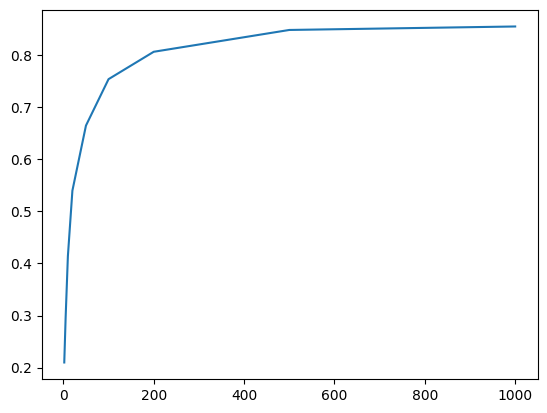

In [ ]:
cluster_sizes = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
accuracies = [sift_svm(cluster_size, trainset, testset) for cluster_size in cluster_sizes]
plt.plot(cluster_sizes, accuracies)

In [ ]:
for i in range(len(cluster_sizes)):
    print(cluster_sizes[i], accuracies[i])

2 0.2098
5 0.2956
10 0.414
20 0.5399
50 0.6649
100 0.7541
200 0.8067
500 0.8486
1000 0.8553


In [ ]:
def sift_svm_tuning(trainset, testset, num_clusters=100, nfeatures=0, sigma=1.6, c=1.0):
    # Create a SIFT object
    print("Num clusters: ", num_clusters)
    sift = cv2.SIFT_create(nfeatures=nfeatures, sigma=sigma)

    # Get descriptors and histograms for training set
    train_descriptors, train_histograms = get_descriptors_and_histograms(trainset, sift, num_clusters)
    print("Descriptors: ", train_descriptors.shape)

    # Create k-means object and fit it to training descriptors
    kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
    kmeans.fit(train_descriptors)

    # Get histograms for test set
    test_descriptors, test_histograms = get_descriptors_and_histograms(testset, sift, num_clusters)

    # Train SVM classifier
    clf = svm.SVC(kernel='linear', C=c)
    clf.fit(train_histograms, [label for _, label in trainset])

    # Test the classifier and compute score
    score = clf.score(test_histograms, [label for _, label in testset])
    print("Score: ", score)

    return score

In [ ]:
print(sift_svm_tuning(trainset, testset, num_clusters=100, nfeatures=0, sigma=1.6, c=1.0))
print(sift_svm_tuning(trainset, testset, num_clusters=100, nfeatures=0, sigma=1.6, c=0.1))
print(sift_svm_tuning(trainset, testset, num_clusters=100, nfeatures=0, sigma=1.6, c=10))
print(sift_svm_tuning(trainset, testset, num_clusters=100, nfeatures=0, sigma=0.8, c=1.0))
print(sift_svm_tuning(trainset, testset, num_clusters=100, nfeatures=0, sigma=3.2, c=1.0))
print(sift_svm_tuning(trainset, testset, num_clusters=100, nfeatures=100, sigma=1.6, c=1.0))
print(sift_svm_tuning(trainset, testset, num_clusters=100, nfeatures=500, sigma=1.6, c=1.0))

Num clusters:  100 
100%|██████████| 10000/10000 [00:25<00:00, 391.38it/s] 
Score:  0.7387 
0.7387 
Num clusters:  100 
100%|██████████| 10000/10000 [00:27<00:00, 369.11it/s]
Score:  0.7306
0.7306
Num clusters:  100
100%|██████████| 10000/10000 [00:25<00:00, 389.14it/s]
Score:  0.7274
0.7274
Num clusters:  100
100%|██████████| 10000/10000 [00:27<00:00, 363.70it/s]
Score:  0.7761
0.7761
Num clusters:  100
100%|██████████| 10000/10000 [00:24<00:00, 415.16it/s]
Score:  0.4979
0.4979
Num clusters:  100
100%|██████████| 10000/10000 [00:27<00:00, 358.33it/s]
Score:  0.7331
0.7331
Num clusters:  100
100%|██████████| 10000/10000 [00:25<00:00, 391.05it/s]
Score:  0.7334
0.7334


# Question 2

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

        self.tanh = nn.Tanh()
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.avgpool(x)

        x = self.conv2(x)
        x = self.tanh(x)
        x = self.avgpool(x)

        x = self.conv3(x)
        x = self.flatten(x)
        x = self.tanh(x)
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
import torch.nn as nn

class LeNet2(LeNet):
    def __init__(self):
        super(LeNet2, self).__init__()
        # Override the architecture defined in the parent class
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(12, 24, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(24, 48, kernel_size=5, stride=1, padding=0)
        self.conv5 = nn.Conv2d(48, 120, kernel_size=5, stride=1, padding=0)


In [ ]:
class TransEncoder(nn.Module):
    def __init__(self):
        super(TransEncoder, self).__init__()
        self.patch_size = 7
        num_patches = (28 // self.patch_size) ** 2
        patch_dim = 1 * self.patch_size ** 2
        self.d_model = 128

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, self.d_model))
        self.patch_to_embedding = nn.Linear(patch_dim, self.d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.d_model))
        self.transfromer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.d_model, nhead=8, batch_first=True), num_layers=2
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.d_model, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        p = self.patch_size

        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)

        x = torch.cat((cls_tokens, x), dim=1)

        x += self.pos_embedding
        x = self.transfromer_encoder(x)

        x = x[:, 0, :]
        x = self.classifier(x)
        return x


In [1]:
def train_and_val_one_epoch(epoch, model, train_loader, test_loader, optimizer, criterion, device, is_training=True):
    if is_training:
        model.train()
        desc = f"Training Epoch {epoch}"
        loader = train_loader
    else:
        model.eval()
        desc = f"Validation Epoch {epoch}"
        loader = test_loader

    running_loss = 0.0
    total_loss = 0.0
    total_acc = 0.0

    for X, y in tqdm(loader, desc=desc, leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(is_training):
            out = model(X)
            loss = criterion(out, y)

            if is_training:
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            total_loss += loss.item()
            total_acc += (out.argmax(1) == y).float().mean().item()

    return total_loss / len(loader), total_acc / len(loader)


In [2]:
def trainer(my_log, lr, opt, batch_size, model_type, num_training_samples=60000, num_epochs=10):
    EPOCHS = num_epochs
    LEARNING_RATE = lr
    BATCH_SIZE = batch_size
    OPTIM = opt
    MODEL_TYPE = model_type
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    train = RandomSampler(trainset, num_samples=num_training_samples)
    test = testset
    train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=train)
    test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

    if MODEL_TYPE == 'lenet':
        model = LeNet().to(DEVICE)
    elif MODEL_TYPE == 'lenet2':
        model = LeNet2().to(DEVICE)
    else:
        model = TransEncoder().to(DEVICE)

    if OPTIM == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    elif OPTIM == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

    criterion = nn.CrossEntropyLoss()

    # Log before training
    train_loss, train_acc = train_and_val_one_epoch(0, model, train_loader, test_loader, optimizer, criterion, DEVICE, is_training=False)
    val_loss, val_acc = train_and_val_one_epoch(0, model, train_loader, test_loader, optimizer, criterion, DEVICE, is_training=False)

    msg = {'train/loss': train_loss, 'train/acc': train_acc, 'val/loss': val_loss, 'val/acc': val_acc}
    for i in msg:
        if i not in my_log.keys():
            my_log[i] = []
        my_log[i].append(msg[i])

    print(f'Epoch: 0, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

    prev_val_loss = val_loss
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_and_val_one_epoch(epoch + 1, model, train_loader, test_loader, optimizer, criterion, DEVICE)
        val_loss, val_acc = train_and_val_one_epoch(epoch + 1, model, train_loader, test_loader, optimizer, criterion, DEVICE)

        print(f'Epoch: {epoch + 1}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

        if val_loss > prev_val_loss:
            print("Early stopping")
            break
        prev_val_loss = val_loss

        msg = {'train/loss': train_loss, 'train/acc': train_acc, 'val/loss': val_loss, 'val/acc': val_acc}
        for i in msg:
            if i not in my_log.keys():
                my_log[i] = []
            my_log[i].append(msg[i])

    return my_log


In [ ]:
my_experiments = []
def exp_run(lr, model_type, optimizer, batch_size=64, num_training_samples=60000, num_epochs=20):
    my_exp_log = {}
    exp_name = f'{model_type}_{optimizer}_lr_{lr}_bs_{batch_size}_n_{num_training_samples}_e_{num_epochs}'
    # pprint({'lr': lr, 'model_type': model_type, 'optimizer': optimizer, 'batch_size': batch_size, 'num_training_samples': num_training_samples})
    print(exp_name)
    my_exp_log = trainer(my_exp_log, lr, optimizer, batch_size, model_type, num_training_samples, num_epochs)
    my_experiments.append({'name': exp_name, 'log': my_exp_log})


In [ ]:
exp_run(0.001, 'lenet', 'adam')

lenet_adam_lr_0.001_bs_64_n_60000


Epoch: 0, Train Loss: 2.3027910515189425, Train Acc: 0.09753131663113006, Val Loss: 2.3028501462025246, Val Acc: 0.09723328025477707


Epoch: 1, Train Loss: 1.5851526750938725, Train Acc: 0.8941064765458422, Val Loss: 1.51145769987896, Val Acc: 0.9551154458598726


Epoch: 2, Train Loss: 1.500696867767936, Train Acc: 0.9637526652452025, Val Loss: 1.4908846070052713, Val Acc: 0.972531847133758


Epoch: 3, Train Loss: 1.4885343572478305, Train Acc: 0.974713486140725, Val Loss: 1.4850115282520366, Val Acc: 0.9785031847133758


Epoch: 4, Train Loss: 1.4830841644486386, Train Acc: 0.9793943230277186, Val Loss: 1.4843977355653313, Val Acc: 0.9786027070063694


Epoch: 5, Train Loss: 1.4792469583594723, Train Acc: 0.9831256663113006, Val Loss: 1.4800428835449704, Val Acc: 0.9814888535031847


Epoch: 6, Train Loss: 1.4770725650319667, Train Acc: 0.9851912313432836, Val Loss: 1.4804676027055, Val Acc: 0.981687898089172
Early stopping


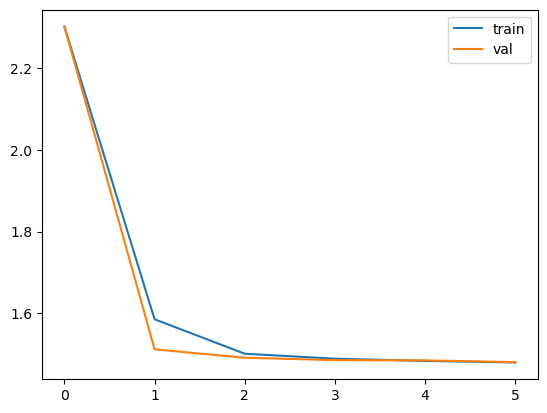

In [ ]:
plt.plot(my_experiments[0]['log']['train/loss'], label='train')
plt.plot(my_experiments[0]['log']['val/loss'], label='val')
plt.legend()

In [ ]:
exp_run(0.001, 'lenet', 'sgd')
exp_run(0.01, 'lenet', 'adam')
exp_run(0.01, 'lenet', 'sgd')
exp_run(0.001, 'lenet', 'adam', batch_size=128)
exp_run(0.001, 'lenet', 'adam', batch_size=32)

lenet_sgd_lr_0.001_bs_64_n_60000


Validation Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 2.302541846151291, Train Acc: 0.10441098081023455, Val Loss: 2.3025796762697257, Val Acc: 0.10260748407643312


Epoch: 1, Train Loss: 2.3025221733142063, Train Acc: 0.10441098081023455, Val Loss: 2.3025371724632895, Val Acc: 0.10260748407643312


Epoch: 2, Train Loss: 2.302480672722432, Train Acc: 0.10442763859275053, Val Loss: 2.302494346715842, Val Acc: 0.10260748407643312


Epoch: 3, Train Loss: 2.3024356657508087, Train Acc: 0.1044776119402985, Val Loss: 2.302451197508794, Val Acc: 0.10260748407643312


Epoch: 4, Train Loss: 2.302393866246189, Train Acc: 0.10446095415778252, Val Loss: 2.3024076489126606, Val Acc: 0.10260748407643312


Epoch: 5, Train Loss: 2.3023515047549186, Train Acc: 0.10442763859275053, Val Loss: 2.3023637586338506, Val Acc: 0.10260748407643312


Epoch: 6, Train Loss: 2.3023093501642062, Train Acc: 0.10441098081023455, Val Loss: 2.3023193049582704, Val Acc: 0.10260748407643312


Epoch: 7, Train Loss: 2.3022646004203033, Train Acc: 0.10439432302771855, Val Loss: 2.302274325850663, Val Acc: 0.10260748407643312


Epoch: 8, Train Loss: 2.3022199508223706, Train Acc: 0.10442763859275053, Val Loss: 2.3022287317142367, Val Acc: 0.10260748407643312


Epoch: 9, Train Loss: 2.3021749280917363, Train Acc: 0.10442763859275053, Val Loss: 2.3021824481380975, Val Acc: 0.10260748407643312


Epoch: 10, Train Loss: 2.3021286334564435, Train Acc: 0.10441098081023455, Val Loss: 2.302135423490196, Val Acc: 0.10260748407643312
lenet_adam_lr_0.01_bs_64_n_60000


Epoch: 0, Train Loss: 2.3028673098793924, Train Acc: 0.0650319829424307, Val Loss: 2.302951650255045, Val Acc: 0.06628184713375797


Epoch: 1, Train Loss: 1.5571992633693508, Train Acc: 0.9077492004264393, Val Loss: 1.5226394591058137, Val Acc: 0.939390923566879


Epoch: 2, Train Loss: 1.5164155863495523, Train Acc: 0.9456623134328358, Val Loss: 1.5031718919231634, Val Acc: 0.9599920382165605


Epoch: 3, Train Loss: 1.5114380646107801, Train Acc: 0.9505263859275054, Val Loss: 1.5189456241146015, Val Acc: 0.9427746815286624
Early stopping
lenet_sgd_lr_0.01_bs_64_n_60000


Epoch: 0, Train Loss: 2.3025053233734325, Train Acc: 0.13071361940298507, Val Loss: 2.302572844134774, Val Acc: 0.12211385350318471


Epoch: 1, Train Loss: 2.301662949356697, Train Acc: 0.162080223880597, Val Loss: 2.300783488401182, Val Acc: 0.17366640127388536


Epoch: 2, Train Loss: 2.299587884183123, Train Acc: 0.2034914712153518, Val Loss: 2.298205097769476, Val Acc: 0.23885350318471338


Epoch: 3, Train Loss: 2.29605204565947, Train Acc: 0.2741204690831556, Val Loss: 2.293141050703207, Val Acc: 0.2906050955414013


Epoch: 4, Train Loss: 2.287137968199594, Train Acc: 0.32772521321961623, Val Loss: 2.277089894956844, Val Acc: 0.4049562101910828


Epoch: 5, Train Loss: 2.2378082867624407, Train Acc: 0.41499533582089554, Val Loss: 2.1701537651620852, Val Acc: 0.3942078025477707


Epoch: 6, Train Loss: 2.084410688770351, Train Acc: 0.4672341417910448, Val Loss: 1.9838267967199823, Val Acc: 0.5634952229299363


Epoch: 7, Train Loss: 1.9127444083502552, Train Acc: 0.6216684434968017, Val Loss: 1.8481132505805629, Val Acc: 0.680234872611465


Epoch: 8, Train Loss: 1.8200325634179593, Train Acc: 0.6961287313432836, Val Loss: 1.7830554899896027, Val Acc: 0.7373606687898089


Epoch: 9, Train Loss: 1.7563678793815662, Train Acc: 0.7691731076759062, Val Loss: 1.721068549308048, Val Acc: 0.8007563694267515


Epoch: 10, Train Loss: 1.7098248878013351, Train Acc: 0.8002232142857143, Val Loss: 1.6862295258576703, Val Acc: 0.8177746815286624
lenet_adam_lr_0.001_bs_128_n_60000


Epoch: 0, Train Loss: 2.302950432559829, Train Acc: 0.09609319474587817, Val Loss: 2.3030219078063965, Val Acc: 0.09355221518987342


Epoch: 1, Train Loss: 1.6331753735857477, Train Acc: 0.8573649609520999, Val Loss: 1.5232935208308547, Val Acc: 0.9449169303797469


Epoch: 2, Train Loss: 1.5122679154247618, Train Acc: 0.9540967040224624, Val Loss: 1.5013187278675129, Val Acc: 0.9639042721518988


Epoch: 3, Train Loss: 1.495297965210384, Train Acc: 0.9692774965310655, Val Loss: 1.4881289593781097, Val Acc: 0.9759691455696202


Epoch: 4, Train Loss: 1.486892978519773, Train Acc: 0.9768290245202559, Val Loss: 1.483963602705847, Val Acc: 0.9785403481012658


Epoch: 5, Train Loss: 1.4827339666992871, Train Acc: 0.980382684832697, Val Loss: 1.4824101939986023, Val Acc: 0.979628164556962


Epoch: 6, Train Loss: 1.4789398484138538, Train Acc: 0.9839807658561511, Val Loss: 1.4819495285613626, Val Acc: 0.9804193037974683


Epoch: 7, Train Loss: 1.477361253838041, Train Acc: 0.9851357054862895, Val Loss: 1.4806452506705174, Val Acc: 0.9810126582278481


Epoch: 8, Train Loss: 1.4753465456749075, Train Acc: 0.9872345860833044, Val Loss: 1.4780152492885348, Val Acc: 0.9838805379746836


Epoch: 9, Train Loss: 1.4745283421677058, Train Acc: 0.9877731876332623, Val Loss: 1.477089883405951, Val Acc: 0.985067246835443


Epoch: 10, Train Loss: 1.4728927978320416, Train Acc: 0.9893112562612684, Val Loss: 1.47745403911494, Val Acc: 0.9847705696202531
Early stopping
lenet_adam_lr_0.001_bs_32_n_60000


Epoch: 0, Train Loss: 2.3026391642252606, Train Acc: 0.05485, Val Loss: 2.302655482063659, Val Acc: 0.05461261980830671


Epoch: 1, Train Loss: 1.5612035945892333, Train Acc: 0.9136333333333333, Val Loss: 1.50476622657654, Val Acc: 0.9604632587859425


Epoch: 2, Train Loss: 1.4975974318186442, Train Acc: 0.9655, Val Loss: 1.4877581162193714, Val Acc: 0.9746405750798722


Epoch: 3, Train Loss: 1.4872123054504394, Train Acc: 0.9754166666666667, Val Loss: 1.4880641950205111, Val Acc: 0.9748402555910544
Early stopping


lenet_adam_lr_0.001_bs_64_n_60000 Final Val Acc: 0.9814888535031847
lenet_sgd_lr_0.001_bs_64_n_60000 Final Val Acc: 0.10260748407643312
lenet_adam_lr_0.01_bs_64_n_60000 Final Val Acc: 0.9599920382165605
lenet_sgd_lr_0.01_bs_64_n_60000 Final Val Acc: 0.8177746815286624
lenet_adam_lr_0.001_bs_128_n_60000 Final Val Acc: 0.985067246835443
lenet_adam_lr_0.001_bs_32_n_60000 Final Val Acc: 0.9746405750798722


Text(0, 0.5, 'Loss')

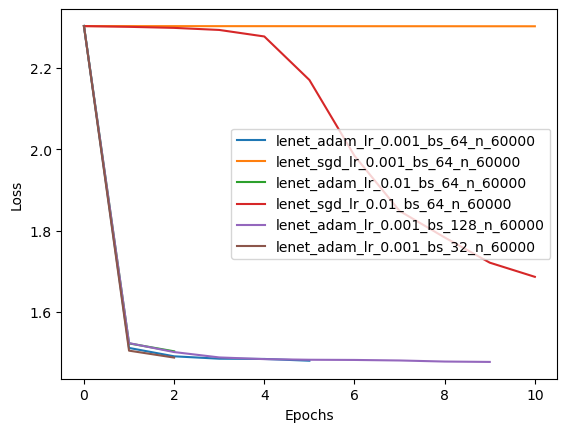

In [ ]:
for e in my_experiments:
    print(e['name'], 'Final Val Acc:', e['log']['val/acc'][-1])

for e in my_experiments:
    plt.plot(e['log']['val/loss'], label=e['name'])

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')


In [ ]:
exp_run(0.001, 'lenet', 'adam', batch_size=128, num_training_samples=600)
exp_run(0.001, 'lenet', 'adam', batch_size=128, num_training_samples=1800)
exp_run(0.001, 'lenet', 'adam', batch_size=128, num_training_samples=6000)
exp_run(0.001, 'lenet', 'adam', batch_size=128, num_training_samples=18000)

lenet_adam_lr_0.001_bs_128_n_600


Epoch: 0, Train Loss: 2.3025170803070067, Train Acc: 0.07073863670229912, Val Loss: 2.3023668723770334, Val Acc: 0.06200553797468354


Epoch: 1, Train Loss: 2.2984052181243895, Train Acc: 0.27258522510528566, Val Loss: 2.2898788572866704, Val Acc: 0.455498417721519


Epoch: 2, Train Loss: 2.2797175884246825, Train Acc: 0.5065340995788574, Val Loss: 2.2590712595589553, Val Acc: 0.5240308544303798


Epoch: 3, Train Loss: 2.236172151565552, Train Acc: 0.503125, Val Loss: 2.1953270042998883, Val Acc: 0.5143393987341772


Epoch: 4, Train Loss: 2.157710599899292, Train Acc: 0.4957386374473572, Val Loss: 2.115903217581254, Val Acc: 0.4762658227848101


Epoch: 5, Train Loss: 2.090666341781616, Train Acc: 0.4839488685131073, Val Loss: 2.0458944719048997, Val Acc: 0.5151305379746836


Epoch: 6, Train Loss: 2.028939628601074, Train Acc: 0.5265625, Val Loss: 1.9775143967399114, Val Acc: 0.5953322784810127


Epoch: 7, Train Loss: 1.9522364377975463, Train Acc: 0.6046875, Val Loss: 1.917060305800619, Val Acc: 0.6544699367088608


Epoch: 8, Train Loss: 1.8990315675735474, Train Acc: 0.6625, Val Loss: 1.8699534301516376, Val Acc: 0.6830498417721519


Epoch: 9, Train Loss: 1.8714987754821777, Train Acc: 0.6684659123420715, Val Loss: 1.8381978424289558, Val Acc: 0.688192246835443


Epoch: 10, Train Loss: 1.8287529468536377, Train Acc: 0.6920454621315002, Val Loss: 1.811661954167523, Val Acc: 0.7065862341772152
lenet_adam_lr_0.001_bs_128_n_1800


Epoch: 0, Train Loss: 2.302622985839844, Train Acc: 0.1, Val Loss: 2.302789446673816, Val Acc: 0.08870648734177215


Epoch: 1, Train Loss: 2.2876831849416095, Train Acc: 0.175, Val Loss: 2.240426051465771, Val Acc: 0.3747033227848101


Epoch: 2, Train Loss: 2.1556290944417316, Train Acc: 0.5369791666666667, Val Loss: 2.016012928153895, Val Acc: 0.6841376582278481


Epoch: 3, Train Loss: 1.9339606682459514, Train Acc: 0.6661458333333333, Val Loss: 1.8338846737825418, Val Acc: 0.720431170886076


Epoch: 4, Train Loss: 1.7787985324859619, Train Acc: 0.7541666666666667, Val Loss: 1.7551613080350659, Val Acc: 0.7661194620253164


Epoch: 5, Train Loss: 1.7376912117004395, Train Acc: 0.7828125, Val Loss: 1.7176068764698655, Val Acc: 0.7887658227848101


Epoch: 6, Train Loss: 1.6995948950449626, Train Acc: 0.8041666666666667, Val Loss: 1.6854387702821176, Val Acc: 0.8140822784810127


Epoch: 7, Train Loss: 1.6824215412139893, Train Acc: 0.8307291666666666, Val Loss: 1.6442391947854924, Val Acc: 0.8754944620253164


Epoch: 8, Train Loss: 1.6291613499323527, Train Acc: 0.88125, Val Loss: 1.6212672960909107, Val Acc: 0.8818235759493671


Epoch: 9, Train Loss: 1.628482413291931, Train Acc: 0.8765625, Val Loss: 1.6047617936436134, Val Acc: 0.8900316455696202


Epoch: 10, Train Loss: 1.6207137902577717, Train Acc: 0.8723958333333334, Val Loss: 1.5976204464707193, Val Acc: 0.8895371835443038
lenet_adam_lr_0.001_bs_128_n_6000


Epoch: 0, Train Loss: 2.30292960937987, Train Acc: 0.0901168313749293, Val Loss: 2.302952488766441, Val Acc: 0.08920094936708861


Epoch: 1, Train Loss: 2.1222606466171587, Train Acc: 0.4122577892973068, Val Loss: 1.8597230926344666, Val Acc: 0.678006329113924


Epoch: 2, Train Loss: 1.737178198834683, Train Acc: 0.7936930098432176, Val Loss: 1.6347992903069606, Val Acc: 0.8744066455696202


Epoch: 3, Train Loss: 1.6179130432453561, Train Acc: 0.8808653126371667, Val Loss: 1.590377836287776, Val Acc: 0.8950751582278481


Epoch: 4, Train Loss: 1.5795349567494494, Train Acc: 0.9003846898992011, Val Loss: 1.564523826671552, Val Acc: 0.9143591772151899


Epoch: 5, Train Loss: 1.5596426902933325, Train Acc: 0.9158197197508304, Val Loss: 1.553104895579664, Val Acc: 0.9212816455696202


Epoch: 6, Train Loss: 1.5580086555886776, Train Acc: 0.9170545225447797, Val Loss: 1.5444725178465057, Val Acc: 0.927314082278481


Epoch: 7, Train Loss: 1.5494646544152118, Train Acc: 0.920521467290026, Val Loss: 1.5404047694387315, Val Acc: 0.9314675632911392


Epoch: 8, Train Loss: 1.5414435229402907, Train Acc: 0.9273841190845409, Val Loss: 1.5331672762013688, Val Acc: 0.935818829113924


Epoch: 9, Train Loss: 1.5351487144510796, Train Acc: 0.9332969239417542, Val Loss: 1.5259314307683631, Val Acc: 0.9424446202531646


Epoch: 10, Train Loss: 1.5277206390462024, Train Acc: 0.9408957070492684, Val Loss: 1.5230610883688624, Val Acc: 0.9451147151898734
lenet_adam_lr_0.001_bs_128_n_18000


Epoch: 0, Train Loss: 2.3023578782453606, Train Acc: 0.09831560286858403, Val Loss: 2.3023096700257892, Val Acc: 0.10047468354430379


Epoch: 1, Train Loss: 1.8221054263148748, Train Acc: 0.6969082448499423, Val Loss: 1.5915641543231434, Val Acc: 0.8965585443037974


Epoch: 2, Train Loss: 1.5701748555433666, Train Acc: 0.9079565604527792, Val Loss: 1.5430908308753484, Val Acc: 0.9300830696202531


Epoch: 3, Train Loss: 1.5393070963257593, Train Acc: 0.9326462766802903, Val Loss: 1.5282873005806645, Val Acc: 0.9412579113924051


Epoch: 4, Train Loss: 1.521203431677311, Train Acc: 0.947129876055616, Val Loss: 1.514245049862922, Val Acc: 0.9527294303797469


Epoch: 5, Train Loss: 1.5106122722017004, Train Acc: 0.9553523938706581, Val Loss: 1.5036399636087538, Val Acc: 0.9629153481012658


Epoch: 6, Train Loss: 1.5056411425272624, Train Acc: 0.9593860815602837, Val Loss: 1.4996264237391799, Val Acc: 0.9644976265822784


Epoch: 7, Train Loss: 1.4973069353306547, Train Acc: 0.9685283687943262, Val Loss: 1.494671660133555, Val Acc: 0.9696400316455697


Epoch: 8, Train Loss: 1.4922023360610854, Train Acc: 0.9731493795171697, Val Loss: 1.4921728417843203, Val Acc: 0.9721123417721519


Epoch: 9, Train Loss: 1.489511359667947, Train Acc: 0.9753989361702128, Val Loss: 1.4894853905786443, Val Acc: 0.9746835443037974


Epoch: 10, Train Loss: 1.4875715184719005, Train Acc: 0.9764184398008576, Val Loss: 1.4866170113599753, Val Acc: 0.9770569620253164


lenet_adam_lr_0.001_bs_128_n_60000 Final Val Acc: 0.985067246835443
lenet_adam_lr_0.001_bs_128_n_600 Final Val Acc: 0.7065862341772152
lenet_adam_lr_0.001_bs_128_n_1800 Final Val Acc: 0.8895371835443038
lenet_adam_lr_0.001_bs_128_n_6000 Final Val Acc: 0.9451147151898734
lenet_adam_lr_0.001_bs_128_n_18000 Final Val Acc: 0.9770569620253164


Text(0, 0.5, 'Loss')

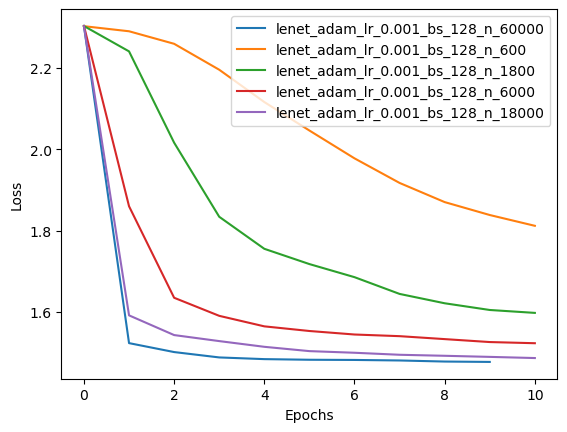

In [ ]:
for e in my_experiments:
    if e['name'][:26] == 'lenet_adam_lr_0.001_bs_128':
        print(e['name'], 'Final Val Acc:', e['log']['val/acc'][-1])

for e in my_experiments:
    if e['name'][:26] == 'lenet_adam_lr_0.001_bs_128':
        plt.plot(e['log']['val/loss'], label=e['name'])

plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')



In [ ]:
exp_run(0.001, 'lenet2', 'adam', batch_size=128)

lenet2_adam_lr_0.001_bs_128_n_60000_e_20


Epoch: 0, Train Loss: 2.3028566613634514, Train Acc: 0.09034625977786111, Val Loss: 2.302902568744708, Val Acc: 0.08959651898734178


Epoch: 1, Train Loss: 1.5754837534829242, Train Acc: 0.9123967217484008, Val Loss: 1.4915626426286335, Val Acc: 0.9740901898734177


Epoch: 2, Train Loss: 1.4897880953258034, Train Acc: 0.9748134328358209, Val Loss: 1.4837753455850142, Val Acc: 0.9792325949367089


Epoch: 3, Train Loss: 1.4822820092060927, Train Acc: 0.9813821517836565, Val Loss: 1.4781977964352957, Val Acc: 0.9848694620253164


Epoch: 4, Train Loss: 1.4786734329357838, Train Acc: 0.9840918176972282, Val Loss: 1.4787501504149618, Val Acc: 0.9837816455696202
Early stopping


In [ ]:
exp_run(0.001, 'trans', 'adam', batch_size=128)

trans_adam_lr_0.001_bs_128_n_60000_e_20


Validation Epoch 0:   1%|          | 5/469 [00:00<00:09, 48.68it/s]

Epoch: 0, Train Loss: 2.3023958063837306, Train Acc: 0.10440542822135791, Val Loss: 2.3025131648099877, Val Acc: 0.10235363924050633


Epoch: 1, Train Loss: 1.8002258889964904, Train Acc: 0.6598036603124411, Val Loss: 1.606450781037536, Val Acc: 0.8555181962025317


Epoch: 2, Train Loss: 1.5983234155915185, Train Acc: 0.863261815962761, Val Loss: 1.5572516963451724, Val Acc: 0.9039754746835443


Epoch: 3, Train Loss: 1.5654558888884749, Train Acc: 0.8954390991471215, Val Loss: 1.565239429473877, Val Acc: 0.8961629746835443
Early stopping


In [ ]:
exp_run(0.0001, 'trans', 'adam', batch_size=128)

trans_adam_lr_0.0001_bs_128_n_60000_e_20


Epoch: 0, Train Loss: 2.3029168460414864, Train Acc: 0.0975035536708608, Val Loss: 2.3028971726381324, Val Acc: 0.09701344936708861


Epoch: 1, Train Loss: 1.8625321629713338, Train Acc: 0.6253331556503199, Val Loss: 1.5775714463825468, Val Acc: 0.896064082278481


Epoch: 2, Train Loss: 1.5787505737499896, Train Acc: 0.8927683014351168, Val Loss: 1.5291756859308556, Val Acc: 0.9366099683544303


Epoch: 3, Train Loss: 1.5491261065387523, Train Acc: 0.9171719528210442, Val Loss: 1.5222094119349612, Val Acc: 0.9417523734177216


Epoch: 4, Train Loss: 1.5344547661128582, Train Acc: 0.9301039445628998, Val Loss: 1.5129615279692639, Val Acc: 0.9488726265822784


Epoch: 5, Train Loss: 1.5235035399129904, Train Acc: 0.9406039001845093, Val Loss: 1.5102275277994857, Val Acc: 0.9522349683544303


Epoch: 6, Train Loss: 1.518278604631485, Train Acc: 0.9446517413358952, Val Loss: 1.5044438084469567, Val Acc: 0.9577729430379747


Epoch: 7, Train Loss: 1.5145595798106082, Train Acc: 0.9481221127357564, Val Loss: 1.5023836651934852, Val Acc: 0.9597507911392406


Epoch: 8, Train Loss: 1.5107912102233627, Train Acc: 0.9517090884861408, Val Loss: 1.4972547866121124, Val Acc: 0.9653876582278481


Epoch: 9, Train Loss: 1.5068275730238794, Train Acc: 0.9558735341151386, Val Loss: 1.4957558007179936, Val Acc: 0.9661787974683544


Epoch: 10, Train Loss: 1.5049218557028374, Train Acc: 0.9577281006109486, Val Loss: 1.4936938979957677, Val Acc: 0.9678599683544303


Epoch: 11, Train Loss: 1.5013895865950757, Train Acc: 0.9611484986632618, Val Loss: 1.492340148249759, Val Acc: 0.9698378164556962


Epoch: 12, Train Loss: 1.4993011765896893, Train Acc: 0.9628142769148609, Val Loss: 1.4934728764280487, Val Acc: 0.9681566455696202
Early stopping


In [ ]:
exp_run(0.0001, 'trans', 'adam', batch_size=128, num_training_samples=6000)

trans_adam_lr_0.0001_bs_128_n_6000_e_20


Epoch: 0, Train Loss: 2.3028288496301528, Train Acc: 0.10220364750699794, Val Loss: 2.302757945241807, Val Acc: 0.10126582278481013


Epoch: 1, Train Loss: 2.3004576500425946, Train Acc: 0.1118683510638298, Val Loss: 2.292185050022753, Val Acc: 0.11362737341772151


Epoch: 2, Train Loss: 2.238111120589236, Train Acc: 0.2179901219428854, Val Loss: 2.1681577465202233, Val Acc: 0.3113132911392405


Epoch: 3, Train Loss: 2.092673885061386, Train Acc: 0.40009973404255317, Val Loss: 1.9749092165427873, Val Acc: 0.5452927215189873


Epoch: 4, Train Loss: 1.9322505022617096, Train Acc: 0.5852488609070473, Val Loss: 1.8376417295842231, Val Acc: 0.6412183544303798


Epoch: 5, Train Loss: 1.8377794001964813, Train Acc: 0.6570573715453453, Val Loss: 1.7821709928633291, Val Acc: 0.6998615506329114


Epoch: 6, Train Loss: 1.7729448840973225, Train Acc: 0.7275123482054853, Val Loss: 1.698348715335508, Val Acc: 0.7931170886075949


Epoch: 7, Train Loss: 1.7113828506875546, Train Acc: 0.7788278879003322, Val Loss: 1.676620208764378, Val Acc: 0.7998417721518988


Epoch: 8, Train Loss: 1.6905084797676573, Train Acc: 0.7899173637653919, Val Loss: 1.6525700710996796, Val Acc: 0.8182357594936709


Epoch: 9, Train Loss: 1.671513745125304, Train Acc: 0.8090330552547536, Val Loss: 1.635528819470466, Val Acc: 0.8428599683544303


Epoch: 10, Train Loss: 1.6370629097553009, Train Acc: 0.8493066113045875, Val Loss: 1.6012509155877028, Val Acc: 0.8759889240506329


Epoch: 11, Train Loss: 1.6327706778303106, Train Acc: 0.8503751906942814, Val Loss: 1.5917551668384406, Val Acc: 0.8847903481012658


Epoch: 12, Train Loss: 1.6077804971248546, Train Acc: 0.8726253813885628, Val Loss: 1.5825676736952383, Val Acc: 0.8883504746835443


Epoch: 13, Train Loss: 1.6036367188108729, Train Acc: 0.8740501530626987, Val Loss: 1.5742239061790178, Val Acc: 0.8965585443037974


Epoch: 14, Train Loss: 1.5987661442858108, Train Acc: 0.8781107537289883, Val Loss: 1.564685812479333, Val Acc: 0.9059533227848101


Epoch: 15, Train Loss: 1.5914827864220802, Train Acc: 0.8802004190201455, Val Loss: 1.5598251336737523, Val Acc: 0.912381329113924


Epoch: 16, Train Loss: 1.583096207456386, Train Acc: 0.8888202892973068, Val Loss: 1.5649517186080353, Val Acc: 0.901503164556962
Early stopping


Convolutional Neural Networks (CNNs) frequently exhibit superior performance compared to conventional methods such as Scale-Invariant Feature Transform (SIFT), Bag of Words (BoW), and Support Vector Machine (SVM) due to the following factors:

Feature Learning: During training, CNNs automatically acquire hierarchical features from raw data. On the contrary, conventional techniques such as SIFT depend on manually constructed feature extraction, which might fail to encompass all pertinent information that is inherent in the data. CNNs are capable of adjusting to the particular attributes of a given dataset, which may result in enhanced performance.

CNNs undergo end-to-end training, during which feature extraction and classification are optimized in tandem. CNNs are thereby capable of acquiring representations that are precisely optimized for the given classification task. On the contrary, conventional approaches frequently necessitate distinct phases for feature extraction and classification, which might not be as congruent with the ultimate objective.

Convolutional layers are employed by CNNs to capture spatial hierarchies of features. By combining the knowledge gained from detecting basic patterns in lower layers, these layers are able to identify more complex patterns in higher layers. The aforementioned hierarchical structure proves advantageous in applications such as image classification, wherein the spatial configurations of objects may differ.

CNNs can derive substantial benefits from data augmentation methods, including random cropping, rotation, and inversion. By subjecting the model to a greater variety of data variations, these methods enhance its capacity to extrapolate to previously unobserved instances.

CNNs make use of parameter sharing, which involves applying the same set of weights to various spatial locations within the input. By doing so, the model's parameter count is diminished and it becomes more conducive to the acquisition of translation-invariant features, which can prove advantageous in applications such as object recognition.

Availability of Large-Scale Data: The availability of large-scale labeled datasets, such as ImageNet, has contributed significantly to the success of CNNs. By being trained on such datasets, CNNs are capable of acquiring comprehensive and generalizable representations of visual data.

CNNs exhibit robustness towards fluctuations in input data, including but not limited to shifts in scale, rotation, and illumination. By acquiring the ability to extract features that remain constant despite these variations, they can attain a level of robustness comparable to that which conventional methods may demand in-depth preprocessing or feature engineering.

Convolutional neural networks (CNNs) have exhibited exceptional performance across various computer vision tasks owing to their end-to-end training paradigm, capability to automatically learn discriminative features from unstructured data, and capability to capture spatial hierarchies of features.